In [11]:
import pandas as pd
import numpy as np 
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
file_path = "C:\\Users\\tonny\\OneDrive\\Desktop\\DAKI2 - Repo\\AI & Data\\Miniprojekt\\medical_students_dataset.csv"

df = pd.read_csv(file_path)

if df is None:
    print("File not valid")

print(df.columns)

Index(['Student ID', 'Age', 'Gender', 'Height', 'Weight', 'Blood Type', 'BMI',
       'Temperature', 'Heart Rate', 'Blood Pressure', 'Cholesterol',
       'Diabetes', 'Smoking'],
      dtype='object')


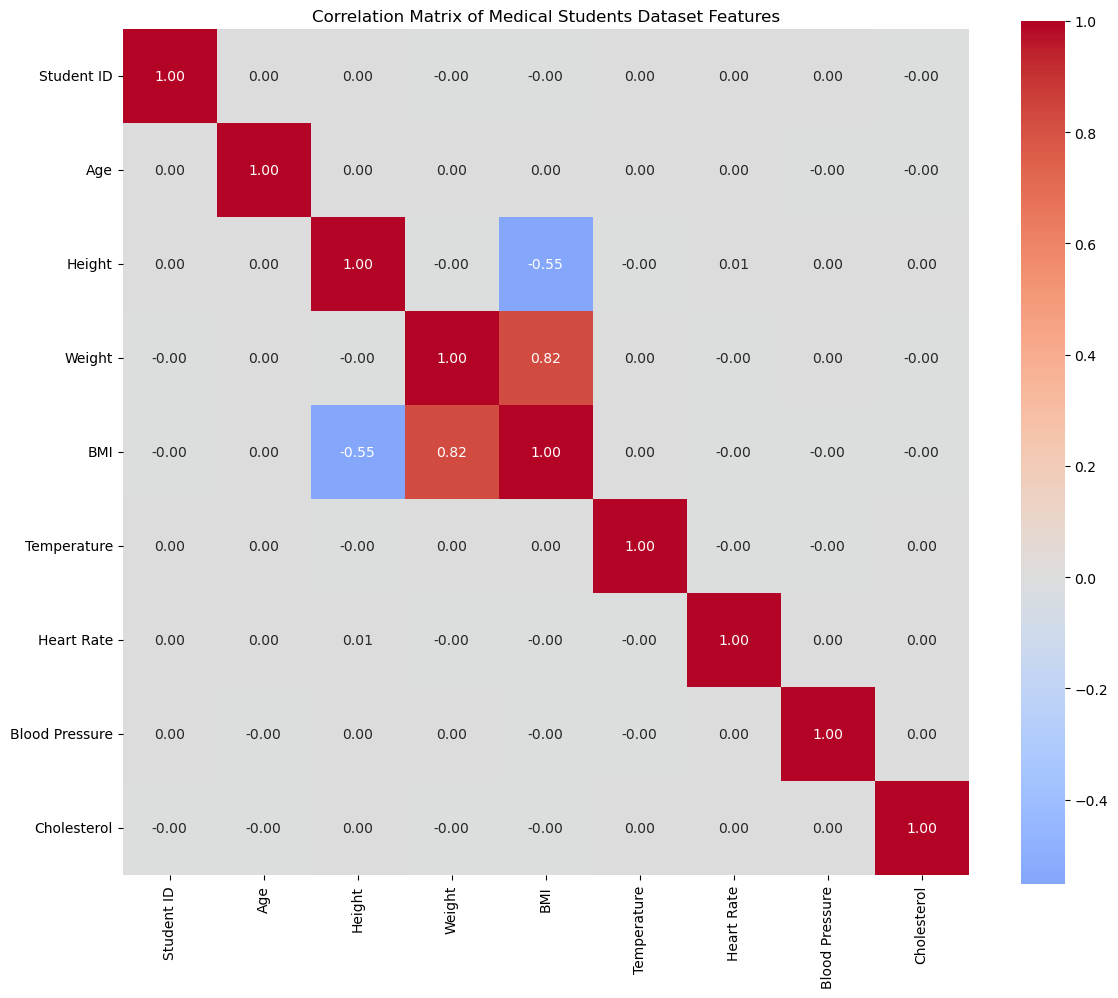

In [ ]:
# Read the dataset
df = pd.read_csv('medical_students_dataset.csv')

# Select numerical columns only
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Create correlation matrix
correlation_matrix = df[numerical_columns].corr()

# Create a figure with a larger size
plt.figure(figsize=(12, 10))

# Create heatmap
sns.heatmap(correlation_matrix, 
            annot=True,  # Show correlation values
            cmap='coolwarm',  # Color scheme
            center=0,  # Center the colormap at 0
            fmt='.2f',  # Round to 2 decimal places
            square=True)  # Make the plot square

# Customize the plot
plt.title('Correlation Matrix of Medical Students Dataset Features')
plt.tight_layout()  # Adjust layout to prevent label cutoff

In [ ]:
''' 
DUPLICATES HANDLING
SLOW but MERGES duplicate row

'''
def first_non_null(series):
    return series.dropna().iloc[0] if not series.dropna().empty else np.nan

# Single-pass solution
result_df = (df.groupby('Student ID', as_index=False)
             .agg(first_non_null)
             .sort_values('Student ID')
             .reset_index(drop=True))

# Remove completely empty rows if needed
df = result_df.dropna(how='all')

In [20]:
'''
DUPLICATES HANDLING
FAST but ONLY KEEPS duplicate rows with LEAST NaN values

'''
# Count missing values per row
df['missing_count'] = df.isna().sum(axis=1)

# Keep the row with the fewest missing values for each Student ID
df = df.loc[df.groupby('Student ID')['missing_count'].idxmin()]

# Drop helper column
df = df.drop(columns='missing_count')

# Sort by Student ID and remove empty rows
df = df.sort_values('Student ID').reset_index(drop=True)

In [21]:
# Use interpolation to add missing Student ID's
df['Student ID'] = df['Student ID'].interpolate(limit_direction='both').astype(float)

In [22]:
# Identify duplicate student_id rows
duplicates = df[df['Student ID'].duplicated()]

# Only proceed if we actually have duplicates
if not duplicates.empty:
    # Count how many times each Student ID occurs
    id_counts = df['Student ID'].value_counts()

    # Only keep counts > 1 (actual duplicates)
    duplicates = id_counts[id_counts > 1]

    # Print the Student IDs which have duplicates
    print("Duplicate counts:")
    print(duplicates)
else:
    print("No duplicates found!")

No duplicates found!


In [23]:
#Imputation for remaining collumns
data = pd.get_dummies(df, columns=['Gender', 'Blood Type', 'Diabetes', 'Smoking'])

imputer = SimpleImputer(strategy='median')
data[['Age', 'Height', 'Weight', 'BMI', 'Heart Rate', 'Blood Pressure', 'Cholesterol', 'Gender_Female', 'Gender_Male', 'Blood Type_A', 'Blood Type_AB', 'Blood Type_B', 'Blood Type_O', 'Diabetes_No', 'Diabetes_Yes', 'Smoking_No', 'Smoking_Yes']] = imputer.fit_transform(data[['Age', 'Height', 'Weight', 'BMI', 'Heart Rate', 'Blood Pressure', 'Cholesterol', 'Gender_Female', 'Gender_Male', 'Blood Type_A', 'Blood Type_AB', 'Blood Type_B', 'Blood Type_O', 'Diabetes_No', 'Diabetes_Yes', 'Smoking_No', 'Smoking_Yes']])

imputer = SimpleImputer(strategy='mean')
data[['Temperature']] = imputer.fit_transform(data[['Temperature']])

In [14]:
print(data.head)

<bound method NDFrame.head of         Student ID   Age  Gender      Height     Weight Blood Type        BMI  \
0              1.0  18.0  Female  161.777924  72.354947          O  27.645835   
1              2.0   NaN    Male  152.069157  47.630941          B        NaN   
2              3.0  32.0  Female  182.537664  55.741083          A  16.729017   
3              NaN  30.0    Male  182.112867  63.332207          B  19.096042   
4              5.0  23.0  Female         NaN  46.234173          O        NaN   
...            ...   ...     ...         ...        ...        ...        ...   
199995         NaN  24.0    Male  176.503260  95.756997          B  30.737254   
199996     99997.0  29.0  Female  163.917675  45.225194        NaN  16.831734   
199997     99998.0  34.0  Female         NaN  99.648914        NaN  33.189303   
199998     99999.0  30.0  Female  156.446944  50.142824          A  20.486823   
199999    100000.0  20.0  Female  153.927409  99.928405          O  42.175189  

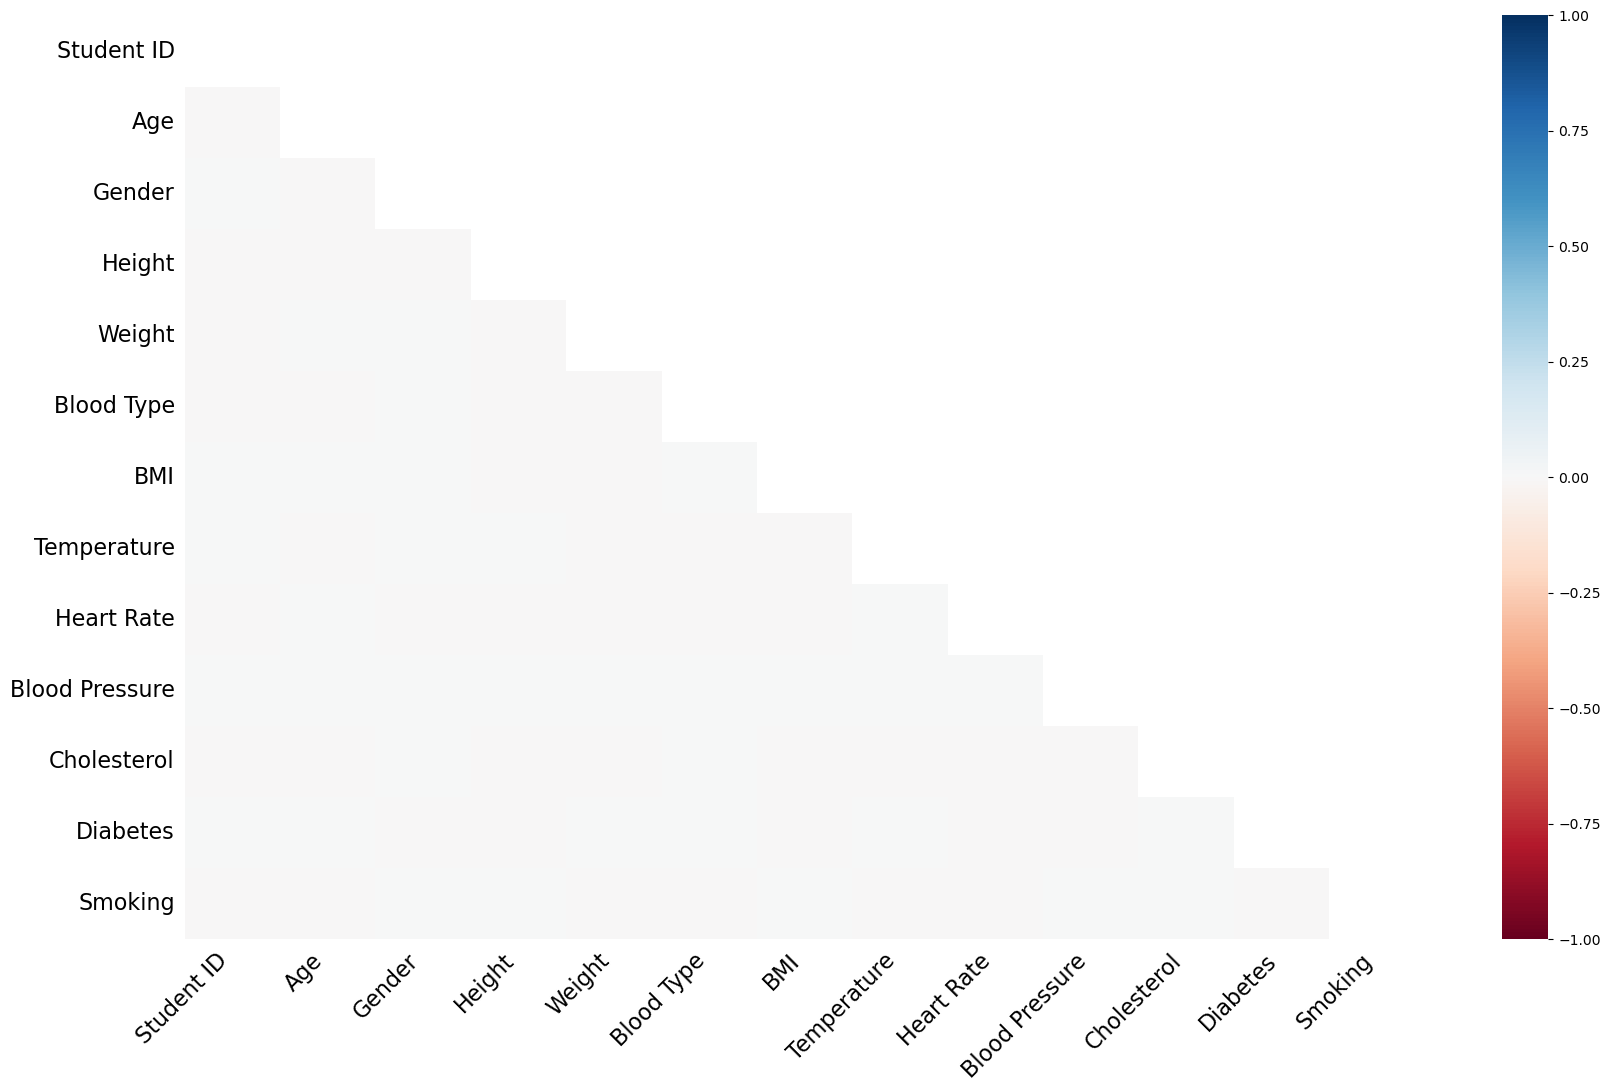

Student ID        20000
Age               20000
Gender            20000
Height            20000
Weight            20000
Blood Type        20000
BMI               20000
Temperature       20000
Heart Rate        20000
Blood Pressure    20000
Cholesterol       20000
Diabetes          20000
Smoking           20000
dtype: int64


In [15]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import  numpy as np

# Load your dataset
data = pd.read_csv('medical_students_dataset.csv')

# Create the heatmap of missingness
msno.heatmap(data)
plt.show()

print(data.isnull().sum())


In [18]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Load your dataset
data = pd.read_csv('medical_students_dataset.csv')

# Create a missingness indicator for the 'Age' column
data['Age_missing'] = data['Age'].isnull().astype(int)



# Choose predictors that are fully or mostly observed; here we use 'Gender', 'Height', and 'Weight' as examples.
# Drop rows with missing values in these predictors to ensure a clean model.
predictors = ['Gender', 'Height', 'Weight']
df = data.dropna(subset=predictors)

# Convert categorical variables to dummy variables (e.g., 'Gender')
# If your dataset uses values like 'Male'/'Female', this will create a dummy variable (e.g., Gender_Male)
df = pd.get_dummies(df, columns=['Gender'], drop_first=True)

# Define the independent variables. Adjust the list based on the dummy variables created.
# For instance, if your Gender column creates a 'Gender_Male' dummy:
X = df[['Height', 'Weight', 'Gender_Male']]
X = sm.add_constant(X)  # Adds an intercept term

X['Gender_Male'] = X['Gender_Male'].astype(int)


# Define the dependent variable (missing indicator for Age)
y = df['Age_missing']

# Fit the logistic regression model
model = sm.Logit(y, X).fit()

# Print the summary of the regression results
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.325578
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            Age_missing   No. Observations:               145751
Model:                          Logit   Df Residuals:                   145747
Method:                           MLE   Df Model:                            3
Date:                Mon, 07 Apr 2025   Pseudo R-squ.:               3.334e-06
Time:                        15:50:30   Log-Likelihood:                -47453.
converged:                       True   LL-Null:                       -47453.
Covariance Type:            nonrobust   LLR p-value:                    0.9569
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -2.2520      0.112    -20.106      0.000      -2.472      -2.032
Height          0.0003    

In [1]:
print(X.head())
print(X.dtypes)
print(y.head())
print(y.dtype)


NameError: name 'X' is not defined